In [1]:
# IMAGE CLASSIFIER - USING TENSORFLOW

import PIL
import pathlib
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from cnn_helper import crop_one_img

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# limit gpu mem usage to 3gb
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# for initial testing, using the greybox images
data_dir = pathlib.Path('../data/img/screenshots/grey_env/')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6000


In [5]:
# Set up 3 classes
dominus = list(data_dir.glob('dominus/*'))
fennec = list(data_dir.glob('fennec/*'))
octane = list(data_dir.glob('octane/*'))

In [6]:
# define loader parameters
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# 80% of images used for training, leaving 20% for validation
# Note: `.image_dataset_from_directory` resizes the images.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6000 files belonging to 3 classes.
Using 4800 files for training.


In [8]:
# create 20% validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6000 files belonging to 3 classes.
Using 1200 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['dominus', 'fennec', 'octane']


## VIZ

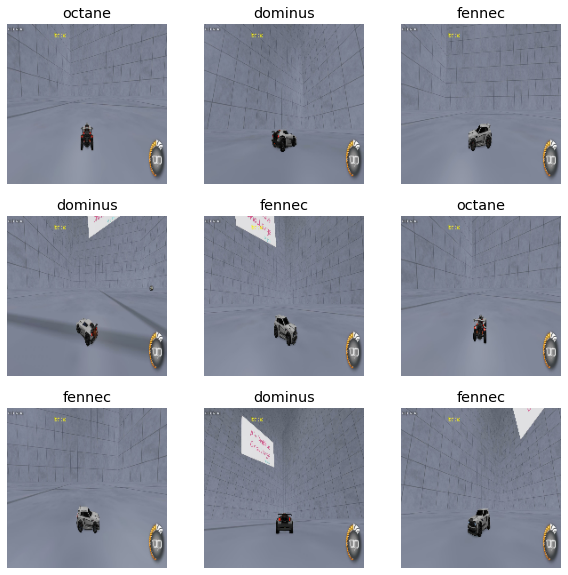

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


### Data Performance Optimization  
from the [tensorflow data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching)  

[Dataset.cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

[Dataset.prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) overlaps data preprocessing and model execution while training. 

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## It's Modeling Time!  

In [15]:
#     ~~ Starting with ~~
# Convolution Blocks: 3
# Fully Connected Layer: 128 units
# Activation: Relu

# Not tuned for high accuracy, this is just the beginning

In [16]:
# Classes: Dominus, Fennec, Octane
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [17]:
# TODO: Why adam?
# TODO: Why SCC loss function?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View all layers of network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Time to train!

In [19]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
150/150 [==============================] - 10s 65ms/step - loss: 0.5171 - accuracy: 0.7885 - val_loss: 0.1543 - val_accuracy: 0.9542
Epoch 2/10
150/150 [==============================] - 2s 16ms/step - loss: 0.1005 - accuracy: 0.9696 - val_loss: 0.0507 - val_accuracy: 0.9783
Epoch 3/10
150/150 [==============================] - 2s 16ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0242 - val_accuracy: 0.9942
Epoch 4/10
150/150 [==============================] - 2s 16ms/step - loss: 0.0206 - accuracy: 0.9940 - val_loss: 0.0194 - val_accuracy: 0.9925
Epoch 5/10
150/150 [==============================] - 2s 16ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0199 - val_accuracy: 0.9967
Epoch 6/10
150/150 [==============================] - 2s 16ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.0102 - val_accuracy: 0.9958
Epoch 7/10
150/150 [==============================] - 2s 16ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.0161 - val_accuracy: 0.995

## Visualize Results

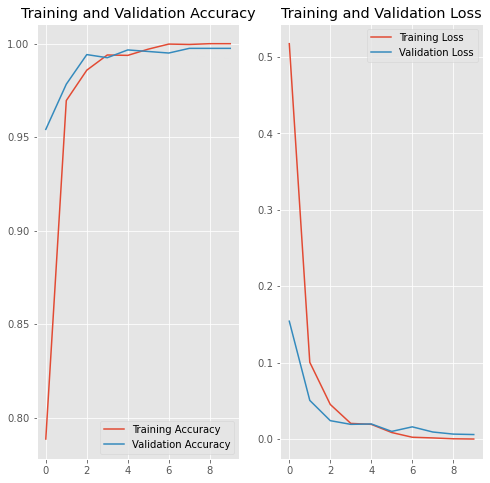

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
# Save entire model in HDF5 format
# for later use in pytorch
model.save(f'../models/tf/model{int(time.time())}.h5')

## Predict on **new** data

In [ ]:
# TODO: get 1000 more screenshots of each class
#       - Varied decals, color, wheels

In [7]:
# an image of a fennec from google
img = keras.preprocessing.image.load_img('../data/img/screenshots/test/fennec.jpeg', target_size=(img_height, img_width))

In [8]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Creates a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NameError: name 'model' is not defined

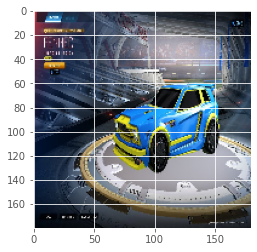

In [10]:
# We can obviously see the prediction is 100% wrong,
# which is to be expected when the model has never
# seen an image like this (colored body, different background)
plt.imshow(img)

In [1]:
"""
TODO: 
x (ss.py) modify for map & car combos

~Get Data~

(rl_body_cnn.py) refactor notebook to work iteratively and viewable in Tensorboard
(cm.py) Tensorboard Confusion Matrix
    -(rl_body_cnn.py) be sure TensorBoard object is instantiated before model
    -(rl_body_cnn.py) be sure to include callback when fitting model

Remove `logs/` from .gitignore if size allows
"""

'\nTODO: \nx (ss.py) modify for map & car combos\n\n~Get Data~\n\n(rl_body_cnn.py) refactor notebook to work iteratively and viewable in Tensorboard\n(cm.py) Tensorboard Confusion Matrix\n    -(rl_body_cnn.py) be sure TensorBoard object is instantiated before model\n    -(rl_body_cnn.py) be sure to include callback when fitting model\n\nRemove `logs/` from .gitignore if size allows\n'

In [11]:
type(img)

PIL.Image.Image

In [7]:
len(dominus)

2000

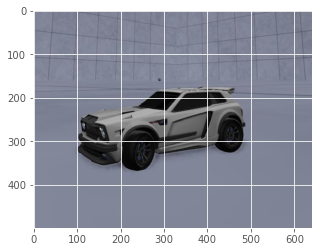

In [7]:
# crop_one_img test
#crop_one_img('../data/img/screenshots/grey_env/fennec/fen_65.jpg', car='fennec')

In [8]:
"""Commented out -- only need to crop once

# crop all dominus
for dom_path in dominus:
    crop_one_img(dom_path, car='dominus')

# crop all fennec
for fen_path in fennec:
    crop_one_img(fen_path, car='fennec')

# crop all octane
for oct_path in octane:
    crop_one_img(oct_path, car='octane')

"""

"Commented out -- only need to crop once\n\n# crop all dominus\nfor dom_path in dominus:\n    crop_one_img(dom_path, car='dominus')\n\n# crop all fennec\nfor fen_path in fennec:\n    crop_one_img(fen_path, car='fennec')\n\n# crop all octane\nfor oct_path in octane:\n    crop_one_img(oct_path, car='octane')\n\n"

In [9]:
#   RUN IT BACK
data_dir = pathlib.Path('../data/img/screenshots/train/cropped/')
# set up classes
dominus = list(data_dir.glob('dominus/*'))
fennec = list(data_dir.glob('fennec/*'))
octane = list(data_dir.glob('octane/*'))

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# load a model
# image to get the weights from
# keras preprocessing img to array

